In [1]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import tqdm
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import os

# Load and Visualize 

In [2]:
# Load data

train_dataset = pd.read_csv(r'stock_dataset\train.csv') 
test_data = pd.read_csv(r'stock_dataset\test.csv')

# Sub data
oil_data = pd.read_csv(r'stock_dataset\oil.csv')
holiday_events = pd.read_csv(r'stock_dataset/holidays_events.csv') 
# Note: We are not using transactions.csv since it doesn't contain data for test.csv

train_dataset[:3]

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0


In [3]:
# Understanding data 
print(f"Min sales: {min(train_dataset['sales'])}")
print(f"Max sales: {max(train_dataset['sales'])}")
print(f"Mean sales: {np.mean(train_dataset['sales'])}")
print(f"Train shape: {train_dataset.shape}")
print(f"Test shape: {test_data.shape}")
print(f"There are {len(train_dataset['sales'][train_dataset['sales'] > 0].unique())} unique values of sales in train data")
print(f"There are {len(train_dataset['sales'][train_dataset['sales'] == 0])} rows with 0 sales in train data")
print(f"There are {len(train_dataset['family'].unique())} unique families")

# Dtypes 
train_dataset.dtypes

Min sales: 0.0
Max sales: 124717.0
Mean sales: 357.77574911261894
Train shape: (3000888, 6)
Test shape: (28512, 5)
There are 379609 unique values of sales in train data
There are 939130 rows with 0 sales in train data
There are 33 unique families


id               int64
date            object
store_nbr        int64
family          object
sales          float64
onpromotion      int64
dtype: object

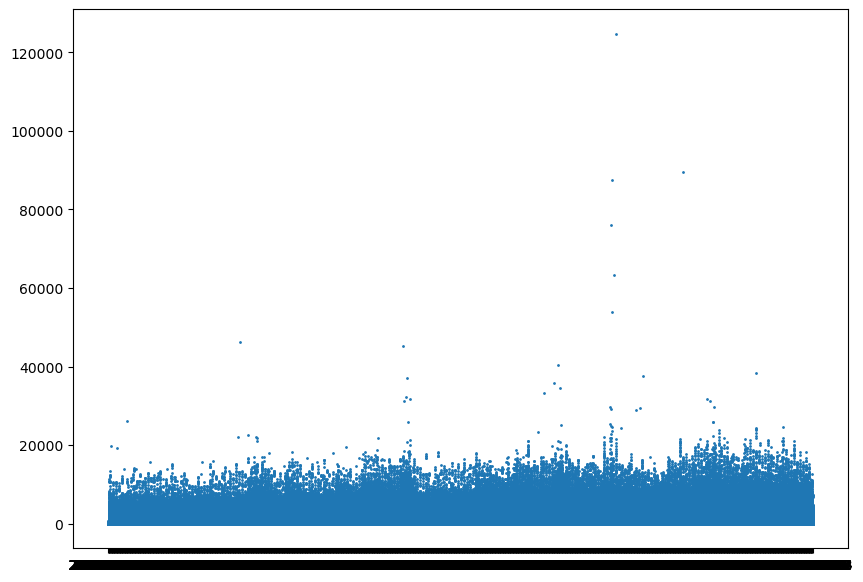

In [4]:
plt.figure(figsize=(10, 7))
plt.scatter(train_dataset['date'][:3000000], train_dataset['sales'][:3000000], s=1)
plt.show()

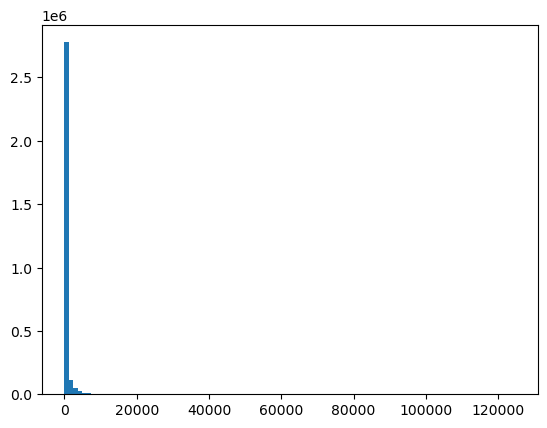

In [5]:
plt.hist(train_dataset['sales'], bins=100)
plt.show()

# Preprocess data

In [6]:
# Check is there any missing values
print(f"Missing values for oil data: {oil_data.isna().sum().sum()}")
print(f"Missing values for holiday data: {holiday_events.isna().sum().sum()}")

Missing values for oil data: 43
Missing values for holiday data: 0


In [7]:
# Function to fill our missing values without losing the informational gain. (Pandas is needed)

def fill_missing_values(dataset_column, decimals: int = 2):
    """ 
    Iterating through the dataset and filling the missing values by mean of previous and next value
    
    Args:
        dataset_column (pandas.DataFrame): Column with missing values to fill
        decimals (int, optional): Number of decimal places to round to
    
    Returns:
        pandas.DataFrame: The filled dataset
    """
    
    # Avoid aliasing
    dataset_column = dataset_column.copy()
    
    # Usual change is the mean of changes in values.
    usual_change = round(dataset_column.diff().dropna().mean(), decimals) # Mean change for every value in the column dataset

    for i in range(0, len(dataset_column)):
        
        if not pd.isna(dataset_column[i]):
            continue
        
        # If the first value is missing
        if i == 0 and pd.isna(dataset_column[i]):
            first_valid_index = dataset_column.first_valid_index() # Find the first non value in the column
            dataset_column[i] = dataset_column[first_valid_index] - usual_change
                
        # If the last value is missing
        elif i == len(dataset_column) - 1:
            # Case: Last value is missing
            if pd.isna(dataset_column[i]):
                dataset_column[i] = dataset_column[i - 1] + usual_change
                            
            # If the last value is not missing, return already filled column
            return dataset_column
        # Handling values in between                            FIX 
        else:
            previous_value = dataset_column[i - 1]
            next_value = dataset_column[i + 1]

            
            if pd.isna(next_value):
                next_value = dataset_column[dataset_column[i+1:].first_valid_index()]
                # If next_value wasn't found, then add the usual change
                if pd.isna(next_value):
                    dataset_column[i] = previous_value + usual_change
                    continue
            dataset_column[i] = round((previous_value + next_value) / 2, 2)
            
    return dataset_column

### **Sub Data: Row Inserting and Processing** 

Let's find all the **"date"** rows that our **oil_price** dataset doesn't have compared with our main datasets. It will help in future with filling our main datasets

In [8]:
# A function that will sync data column in sub data with our training and test data
def sync_data_column(sub_data, train_data, test_data):
    """ 
    This function will sync data column in sub data with our training and test data
    
    Args:
        sub_data (pandas.DataFrame): The sub data to sync
        train_data (pandas.DataFrame): The training data
        test_data (pandas.DataFrame): The test data
    
    Returns:
        pandas.DataFrame: provided sub_data with added date columns (Synced columns will contain missing values)
    """

    missing_dates_train = train_dataset[~train_dataset['date'].isin(sub_data['date'])]['date'].unique()
    missing_dates_test = test_data[~test_data['date'].isin(sub_data['date'])]['date'].unique()

    # Convert back to dataframe 
    missing_dates_train = pd.DataFrame(missing_dates_train, columns=['date'])
    missing_dates_test = pd.DataFrame(missing_dates_test, columns=['date'])

    # Fill for train and test
    sub_data = pd.concat([sub_data, missing_dates_train], ignore_index=True).sort_values(by='date').reset_index(drop=True)
    sub_data = pd.concat([sub_data, missing_dates_test], ignore_index=True).sort_values(by='date').reset_index(drop=True)


    return sub_data

In [9]:
%%time
# Sync oil data with train and test dataset
oil_data = sync_data_column(oil_data, train_dataset, test_data)
print(f"Missing values for oil data before: {oil_data.isna().sum().sum()}")

# Fill missing values
oil_data["oil_price"] = fill_missing_values(oil_data["dcoilwtico"])
oil_data.drop(columns=["dcoilwtico"], axis=1, inplace=True)

print(f"Missing values for oil data after: {oil_data.isna().sum().sum()}")

# Show missing values 
oil_data.head(10)

Missing values for oil data before: 528
Missing values for oil data after: 0
CPU times: total: 281 ms
Wall time: 276 ms


,date,oil_price
0,2013-01-01,93.13
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-05,93.16
5,2013-01-06,93.18
6,2013-01-07,93.20
7,2013-01-08,93.21
8,2013-01-09,93.08
9,2013-01-10,93.81


### Preprocess holidays data

In [10]:
holiday_events.drop(columns=["description"], axis=1, inplace=True)
holiday_events['locale_name'] = holiday_events['locale_name'].str.lower()
# Sync data with train and test dataset
holiday_events = sync_data_column(holiday_events, train_dataset, test_data)

len(holiday_events['locale_name'].unique()) # 24 - Then we are going to encode it.

print(f"Missing values for holiday data: {holiday_events.isna().sum().sum()}")
print(f"There are {len(holiday_events['locale_name'].unique())} unique locales in holiday data")
holiday_events.head(1000)

Missing values for holiday data: 5788
There are 25 unique locales in holiday data


,date,type,locale,locale_name,transferred
0,2012-03-02,Holiday,Local,manta,False
1,2012-04-01,Holiday,Regional,cotopaxi,False
2,2012-04-12,Holiday,Local,cuenca,False
3,2012-04-14,Holiday,Local,libertad,False
4,2012-04-21,Holiday,Local,riobamba,False
...,...,...,...,...,...
995,2015-07-30,NaN,NaN,NaN,NaN
996,2015-07-31,NaN,NaN,NaN,NaN
997,2015-08-01,NaN,NaN,NaN,NaN
998,2015-08-02,NaN,NaN,NaN,NaN


In [11]:
# Use ffill method on holiday data
holiday_events = holiday_events.ffill(axis=0)

# Any missing values? 
print(f"Missing values for holiday data: {holiday_events.isna().sum().sum()}")

Missing values for holiday data: 0


C:\Users\chupr\AppData\Local\Temp\ipykernel_21556\2186577363.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  holiday_events = holiday_events.ffill(axis=0)


### **Preprocessing Main Datasets**

In [12]:
pd.to_datetime(test_data['date']).dt.date

0        2017-08-16
1        2017-08-16
2        2017-08-16
3        2017-08-16
4        2017-08-16
            ...    
28507    2017-08-31
28508    2017-08-31
28509    2017-08-31
28510    2017-08-31
28511    2017-08-31
Name: date, Length: 28512, dtype: object

In [13]:
%%time
# Convert date column to datetime
train_dataset['date'] = pd.to_datetime(train_dataset['date']).astype('datetime64[ns]')
test_data['date'] = pd.to_datetime(test_data['date']).astype('datetime64[ns]')
oil_data['date'] = pd.to_datetime(oil_data['date']).astype('datetime64[ns]')
holiday_events['date'] = pd.to_datetime(holiday_events['date']).astype('datetime64[ns]')

# Merge train and test datasets with oil prices based on date
train_dataset = train_dataset.merge(oil_data, on="date", how="left")
train_dataset = train_dataset.merge(holiday_events, on="date", how="left")

test_data = test_data.merge(oil_data, on="date", how="left")
test_data = test_data.merge(holiday_events, on="date", how="left")

# Are there any missing values
print(f"Missing values for train dataset: {train_dataset.isna().sum().sum()}")
print(f"Missing values for test dataset: {test_data.isna().sum().sum()}")

train_dataset.columns

Missing values for train dataset: 0
Missing values for test dataset: 0
CPU times: total: 1.12 s
Wall time: 1.24 s


Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion',
       'oil_price', 'type', 'locale', 'locale_name', 'transferred'],
      dtype='object')

### Additional Note: Wages in the public sector are paid every two weeks on the 15th and on the last day of the month. Supermarket sales could be affected by this.

In [14]:
# Function to determine if a date is the last day of the month
def is_last_day_of_month(date):
    next_day = date + pd.Timedelta(days=1)
    return next_day.month != date.month

train_df = train_dataset.copy()
test_df = train_dataset.copy()

# Add new columns for wage payment indicators
train_df['Is_15th'] = train_df['date'].dt.day == 15
train_df['Is_Last_Day'] = train_df['date'].apply(is_last_day_of_month)

test_df['Is_15th'] = train_df['date'].dt.day == 15
test_df['Is_Last_Day'] = train_df['date'].apply(is_last_day_of_month)

# Concatenate into one column 
train_dataset["WageDay"] = train_df['Is_15th'] | train_df['Is_Last_Day']
test_data["WageDay"] = test_df['Is_15th'] | test_df['Is_Last_Day']

del train_df
del test_df

train_dataset["WageDay"]

0          False
1          False
2          False
3          False
4          False
           ...  
3054343     True
3054344     True
3054345     True
3054346     True
3054347     True
Name: WageDay, Length: 3054348, dtype: bool

In [15]:
def extract_date(df, date_col):
    df[date_col]                     = pd.to_datetime(df[date_col])
    df[f'year {date_col}']           = df[date_col].dt.year.astype(int)
    df[f'month {date_col}']          = df[date_col].dt.month.astype(int)
    df[f'day {date_col}']            = df[date_col].dt.day.astype(int)
    df[f'day of week {date_col}']    = df[date_col].dt.dayofweek.astype(int)
    df[f'week of year {date_col}']   = df[date_col].dt.isocalendar().week.astype(int)
    df[f'quarter {date_col}']        = df[date_col].dt.quarter.astype(int)
    df[f'is weekend {date_col}']     = df[f'day of week {date_col}'].isin([5, 6]).astype(int)
    df[f'is leap year {date_col}']   = df[date_col].dt.is_leap_year.astype(int)
    df[f"is_month_end {date_col}"]   = df[date_col].dt.is_month_end.astype(int)
    df[f"is_month_start {date_col}"] = df[date_col].dt.is_month_start.astype(int)

In [16]:
# Finish preprocessing

# Drop the date and id columns, since not even small informational gain.
train_dataset.drop(columns=['id'], inplace=True)
test_data.drop(columns=['id'], inplace=True)

# Extract date 
extract_date(train_dataset, 'date') # type: ignore
extract_date(test_data, 'date') # type: ignore

# Replace true and false for 1 and 0 in transferred column
train_dataset['transferred'] = train_dataset['transferred'].astype(int)
train_dataset['WageDay'] = train_dataset['WageDay'].astype(int)
test_data['transferred'] = test_data['transferred'].astype(int)
test_data['WageDay'] = test_data['WageDay'].astype(int)

# Encoding
label_encoder = LabelEncoder()

train_dataset['family'] = label_encoder.fit_transform(train_dataset['family']).astype(np.int64)
train_dataset['type'] = label_encoder.fit_transform(train_dataset['type']).astype(np.int64)
train_dataset['locale'] = label_encoder.fit_transform(train_dataset['locale']).astype(np.int64)
train_dataset['locale_name'] = label_encoder.fit_transform(train_dataset['locale_name']).astype(np.int64)

test_data['family'] = label_encoder.fit_transform(test_data['family']).astype(np.int64)
test_data['type'] = label_encoder.fit_transform(test_data['type']).astype(np.int64)
test_data['locale'] = label_encoder.fit_transform(test_data['locale']).astype(np.int64)
test_data['locale_name'] = label_encoder.fit_transform(test_data['locale_name']).astype(np.int64)


train_dataset[:3]

,date,store_nbr,family,sales,onpromotion,oil_price,type,locale,locale_name,transferred,...,year date,month date,day date,day of week date,week of year date,quarter date,is weekend date,is leap year date,is_month_end date,is_month_start date
0,2013-01-01,1,0,0.0,0,93.13,3,1,4,0,...,2013,1,1,1,1,1,0,0,0,1
1,2013-01-01,1,1,0.0,0,93.13,3,1,4,0,...,2013,1,1,1,1,1,0,0,0,1
2,2013-01-01,1,2,0.0,0,93.13,3,1,4,0,...,2013,1,1,1,1,1,0,0,0,1


### Split Dataset

In [17]:
# Split training data (80% train, 20% validation)
split = int(len(train_dataset) * 0.8)
train_dataset, validation_dataset = train_dataset[:split], train_dataset[split:]

len(train_dataset), len(validation_dataset)

(2443478, 610870)

Three ways to organize our data: 
- 1. Do nothing. Leave the data unbalanced, we are getting more samples, but the predictions are awful and not correct.
- 2. Delete all zero sales. Good way, but then there's no probability for zeros. 
- 3. Leave a small percent of all zeros in our dataset. So when we are going to predict, the model will also count the probabilities of data to be zero sales. 

In [18]:
# How much zero sales in our dataset? # How much sales > 0 in our dataset?
len(train_dataset[train_dataset["sales"] == 0]), len(train_dataset[train_dataset["sales"] > 0])

(854818, 1588660)

In [19]:
def method_preprocessing(dataset, method: int): 
    # Method 1: Do nothing
    if method == 1: 
        return dataset
    elif method == 2: 
        # Delete all zero sales. Good way, but then there's no probability for zeros.
        dataset = dataset[dataset["sales"] > 0] 
        return dataset
    elif method == 3: 
        # Leave 10% of all zeros in our dataset.  
        zero_sales = dataset[dataset['sales'] == 0]
        non_zero_sales = dataset[dataset['sales'] > 0]

        # Undersample the zero sales data to 20%
        zero_sales = zero_sales.sample(frac=0.2, random_state=42)

        # Combine the undersampled zero sales with the non-zero sales
        dataset = pd.concat([zero_sales, non_zero_sales])

        # Shuffle the data
        dataset = dataset.sample(frac=1, random_state=42).reset_index(drop=True)

        # Sort by the date 
        dataset = dataset.sort_values(by='date').reset_index(drop=True)
        
        return dataset
    else: 
        raise ValueError(f"Method {method} is not implemented.")

In [20]:
train_dataset = method_preprocessing(train_dataset, method=3)

# Length after undersampling
len(train_dataset[train_dataset["sales"] == 0]), len(train_dataset[train_dataset["sales"] > 0])

(170964, 1588660)

In [21]:
## Are there are missing values? 
train_dataset.isnull().sum(), len(train_dataset)

(date                   0
 store_nbr              0
 family                 0
 sales                  0
 onpromotion            0
 oil_price              0
 type                   0
 locale                 0
 locale_name            0
 transferred            0
 WageDay                0
 year date              0
 month date             0
 day date               0
 day of week date       0
 week of year date      0
 quarter date           0
 is weekend date        0
 is leap year date      0
 is_month_end date      0
 is_month_start date    0
 dtype: int64,
 1759624)

# Save processed data 

In [23]:
train_file = r"preprocessed_dataset\test_dataset.csv"

# Save data
if not os.path.exists(train_file): 
    train_dataset = train_dataset.to_csv(r'preprocessed_dataset\train_dataset.csv', index=False)
    # No sampling for validation_dataset for correct evaluation.
    validation_dataset = validation_dataset.to_csv(r'preprocessed_dataset\validation_dataset.csv', index=False)
    test_data = test_data.to_csv(r'preprocessed_dataset\test_dataset.csv', index=False)
    print(f"Data was succesfully saved.")
else: 
    print(f'File {train_file} already exists and will not be overwritten.')

Data was succesfully saved.
